<a href="https://colab.research.google.com/github/NicoM59/dsfs_od_4_projet_final_ana__nico/blob/main/mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Détection et classification de troubles mentaux (NLP)
**Objectif :** prédire la classe `category` à partir du texte `body` (posts).  
**Priorité clinique :** minimiser les *faux négatifs* sur **Schizophrenia** et **Bipolar** (classes critiques).

---

## 📋 Plan du notebook
### Phase 1 — Exploration Approfondie des Données (EDA)
1. Chargement & nettoyage
2. Analyse descriptive globale
3. Analyse par classe (déséquilibre, longueurs, exemples)
4. Analyse linguistique (mots fréquents)
5. Visualisations clés

### Phase 2 — Modélisation Baseline et Itérations
1. Préparation (split fixe, masquage)
2. Baselines TF‑IDF + modèles linéaires
3. Tuning orienté *recall critique*
4. Score hybride (TF‑IDF + features linguistiques)
5. Comparaison **avec / sans masquage**
6. Modèles Transformers (BERT) + limites (modèles gated)
7. Tableau comparatif final & choix du modèle

> Tout le texte/commentaires sont en **français**.  
> Les colonnes du dataset restent **`body`** (texte) et **`category`** (label).


In [6]:
# ✅ Setup (Colab)
# Exécute cette cellule 1x, puis fais: Runtime > Restart runtime (si Colab le demande)
%pip install -q numpy==1.26.6
%pip install -q -U pandas scikit-learn matplotlib transformers datasets accelerate evaluate beautifulsoup4 rapidfuzz datasketch wordcloud ftfy

import sys, torch
print("Python:", sys.version)
print("CUDA available:", torch.cuda.is_available())

ERROR: Ignored the following yanked versions: 2.4.0
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.26.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 

In [1]:
# Imports (une seule fois)
import re, html, unicodedata, string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, recall_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# optionnel (near-duplicates)
from datasketch import MinHash, MinHashLSH
from bs4 import BeautifulSoup

# optionnel (corrige textes "cassés" type yÛªall)
try:
    from ftfy import fix_text
except Exception:
    fix_text = None

pd.set_option("display.max_colwidth", 120)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Chargement du dataset
**Pourquoi :** on commence par figer le format d’entrée (colonnes `body` et `category`) et vérifier les valeurs manquantes / anomalies.  
**Conclusion attendue :** un `DataFrame` propre, sans lignes vides, prêt pour EDA + modélisation.


In [3]:
# ⚠️ À adapter : place ton fichier CSV à côté du notebook / dans Colab
# Exemple Colab: upload -> fichier dans /content/
DATA_PATH = "/content/drive/MyDrive/mental_health/mental_health_detection.csv"

df_raw = pd.read_csv(DATA_PATH)
print(df_raw.info())
df_raw


<class 'pandas.DataFrame'>
RangeIndex: 11349 entries, 0 to 11348
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   body      11279 non-null  str  
 1   category  11342 non-null  str  
dtypes: str(2)
memory usage: 13.0 MB
None


,body,category
0,I often find myself checking on old friends on Facebook and seeing them enjoy life together I miss them and feel sad...,Depression
1,this is not a post asking if i have add depression or anxiety this is a post asking about an upcoming assessment and...,ADHD
2,i went to my gp the other day to pick a new prescription of adderall out of the blue a nurse hands me a piss cup and...,ADHD
3,im a morning person and always envied stories of people pulling allnighters and staying up into the wee hours to sta...,ADHD
4,im preparing to be rediagnosed for adhd as im a senior in college i have struggled with it my entire life and have b...,ADHD
...,...,...
11344,NaN,BPD
11345,NaN,schizophrenia
11346,NaN,schizophrenia
11347,NaN,schizophrenia


In [4]:
# Vérification rapide des valeurs manquantes / vides
TEXT_COL = "body"
TARGET_COL = "category"

# 1️⃣ Remove NaN primeiro (boa prática)
df_raw = df_raw.dropna(subset=[TEXT_COL, TARGET_COL])

# 2️⃣ Remove espaços invisíveis (ex: \xa0)
df_raw[TEXT_COL] = df_raw[TEXT_COL].str.replace('\xa0', ' ', regex=False)

# 3️⃣ Remove espaços no início e fim
df_raw[TEXT_COL] = df_raw[TEXT_COL].str.strip()
df_raw[TARGET_COL] = df_raw[TARGET_COL].str.strip()

# 4️⃣ Remove múltiplos espaços internos
df_raw[TEXT_COL] = df_raw[TEXT_COL].str.replace(r'\s+', ' ', regex=True)
df_raw

,body,category
0,I often find myself checking on old friends on Facebook and seeing them enjoy life together I miss them and feel sad...,Depression
1,this is not a post asking if i have add depression or anxiety this is a post asking about an upcoming assessment and...,ADHD
2,i went to my gp the other day to pick a new prescription of adderall out of the blue a nurse hands me a piss cup and...,ADHD
3,im a morning person and always envied stories of people pulling allnighters and staying up into the wee hours to sta...,ADHD
4,im preparing to be rediagnosed for adhd as im a senior in college i have struggled with it my entire life and have b...,ADHD
...,...,...
11292,Your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput Autistic...,Autism
11293,Your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput Autistic...,Autism
11294,Youre a person You also have needs You dont have to be there for the person 247 You dont need to be the emotionally ...,BPD
11295,youre a piece of shit and i hate that i cant stop being nice and empathetic because god i cant imagine what its like...,Bipolar


In [5]:
df_raw.isnull().sum()



body        0
category    0
dtype: int64

In [ ]:
print(repr(df_raw.loc[4, "body"]))

'im preparing to be rediagnosed for adhd as im a senior in college i have struggled with it my entire life and have been diagnosed twice however two years ago i had my daughter and i was put on prozac this is great takes the edge off etc i feel though now that i am in the toughest classes that i dont have the ability to achieve my full potential last semester i had relatively easy classes so i ended up with a 38 gpa however this was not easy i had a dose of 40mgday putting me into a very sleepy content i had to drink a lot of caffeine to be able to stay awake for classes as well as have energy for my daughter it takes a lot to be able to keep up with my two year old a husband that works nights as well as go to school full time and work part time but i know that because i have a kid i have to keep going if i just let one slip up it will all crumble well when i decided that a rediagnosis was an excellent idea scheduling an appointment for such a certain family member called me out statin

## 2) Nettoyage texte & normalisation des labels
**Pourquoi :**  
- Le nettoyage réduit le bruit (HTML, caractères de contrôle, espaces multiples, URLs).  
- La normalisation des labels évite d’avoir des classes dupliquées à cause de la casse / espaces (`schizophrenia` vs `Schizophrenia`).  

**Conclusion :** création de `df` (propre) + labels homogènes.


In [6]:
# =========================
# 2.1) Nettoyage texte
# =========================
# zero-width + BOM (sem caracteres invisíveis no código)
# U+200B (ZWSP), U+200C (ZWNJ), U+200D (ZWJ), U+2060 (WORD JOINER), U+FEFF (BOM)
ZERO_WIDTH_RE = re.compile(r'[\u200B\u200C\u200D\u2060\uFEFF]')  # zero-width + BOM

# Control chars (ASCII + C1), incluindo DEL
CONTROL_RE = re.compile(r'[\x00-\x1F\x7F-\x9F]')

# URLs
URL_RE = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\"”‘’]))')

def strip_html_tags(s: str) -> str:
    if "<" in s and ">" in s:
        return BeautifulSoup(s, "html.parser").get_text(" ")
    return s

def clean_body(text: str) -> str:
    if text is None:
        return ""
    t = str(text)

    if fix_text is not None:
        t = fix_text(t) # corrige des caractères mal encodés (ex: yÛªall)

    t = ZERO_WIDTH_RE.sub("", t) # Supprime les caractères zero-width
    t = CONTROL_RE.sub("", t) # Supprime les caractères de contrôle
    t = strip_html_tags(t)
    t = html.unescape(t) # décode les entités HTML (ex: &amp; -> &)
    t = URL_RE.sub("[URL]", t) # remplace les URLs par un token
    t = unicodedata.normalize("NFKD", t).encode("ascii", "ignore").decode("utf-8") # normalise et retire accents

    # Nettoyage générique
    t = t.replace("\n", " ")
    t = t.replace("\r", " ")
    t = t.replace("\t", " ")
    t = re.sub(r"\s+", " ", t) # remplace les espaces multiples par un seul
    t = t.strip() # retire les espaces en début/fin
    return t


In [7]:
# =========================
# 2.2) Normalisation des labels
# =========================
LABEL_CANON = {
    "autism": "Autism",
    "anxiety": "Anxiety",
    "adhd": "ADHD",
    "add": "ADHD",
    "depression": "Depression",
    "schizophrenia": "Schizophrenia",
    "bipolar": "Bipolar",
    "bpd": "BPD",
    "ptsd": "PTSD",
    "ocd": "OCD",
}

def normalize_label(x) -> str:
    # Important (Colab/CSV): les NaN deviennent parfois la chaîne "nan" -> on les supprime
    if x is None or (isinstance(x, float) and pd.isna(x)) or (isinstance(x, str) and x.strip().casefold() == "nan"):
        return ""
    if pd.isna(x):
        return ""
    x = str(x).strip()
    key = x.casefold()
    return LABEL_CANON.get(key, x)

df = df_raw.copy()
df[TEXT_COL] = df[TEXT_COL].map(clean_body)
df[TARGET_COL] = df[TARGET_COL].map(normalize_label)

# supprimer vides
df = df[df[TEXT_COL].str.strip().ne("")]
df = df[df[TARGET_COL].str.strip().ne("")]

# optionnel: enlever les lignes placeholder "NAME"
df = df[(df[TEXT_COL].str.strip().ne("NAME")) & (df[TARGET_COL].str.strip().ne("NAME"))]

# ✅ Sécurité pour la validation croisée: retirer les labels trop rares (sinon StratifiedKFold plante)
N_SPLITS = 5
counts = df[TARGET_COL].value_counts()
rare = counts[counts < N_SPLITS].index.tolist()
if rare:
    print("Labels trop rares (retirés):", rare)
    df = df[~df[TARGET_COL].isin(rare)]

print("N après nettoyage minimal:", len(df))
print("Labels uniques:", sorted(df[TARGET_COL].unique()))
df[TARGET_COL].value_counts()
df


N après nettoyage minimal: 11270
Labels uniques: ['ADHD', 'Anxiety', 'Autism', 'BPD', 'Bipolar', 'Depression', 'Schizophrenia']


,body,category
0,I often find myself checking on old friends on Facebook and seeing them enjoy life together I miss them and feel sad...,Depression
1,this is not a post asking if i have add depression or anxiety this is a post asking about an upcoming assessment and...,ADHD
2,i went to my gp the other day to pick a new prescription of adderall out of the blue a nurse hands me a piss cup and...,ADHD
3,im a morning person and always envied stories of people pulling allnighters and staying up into the wee hours to sta...,ADHD
4,im preparing to be rediagnosed for adhd as im a senior in college i have struggled with it my entire life and have b...,ADHD
...,...,...
11291,Youre allowed to look bored Youre allowed to look disinterested Youre allowed to not care about things you dont care...,Anxiety
11292,Your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput Autistic...,Autism
11293,Your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput Autistic...,Autism
11294,Youre a person You also have needs You dont have to be there for the person 247 You dont need to be the emotionally ...,BPD


## 3) (Optionnel) Détection de near-duplicates (MinHash/LSH)
**Pourquoi :** certains posts peuvent être quasi identiques (copiés/collés, cross-posts).  
Si on les laisse, on risque de surestimer la performance (le modèle “reconnaît” le duplicat).  

**Conclusion :** on garde **1** représentant par groupe de near-duplicates.
> ⚠️ Cette étape peut être plus lente. Tu peux la sauter si besoin.


In [8]:
# =========================
# 3) Near-duplicates (MinHash/LSH) + FORÇA lowercase
# =========================
TEXT_COL = "body"

WORD_RE = re.compile(r"\w+", flags=re.UNICODE)

def word_shingles(text: str, n: int = 3):
    # ✅ força lowercase para TODO o texto antes de tokenizar
    text = str(text).lower()
    toks = WORD_RE.findall(text)
    if len(toks) < n:
        return toks
    return [" ".join(toks[i:i+n]) for i in range(len(toks) - n + 1)]

def text_to_minhash(text: str, num_perm: int = 128, shingle_n: int = 3) -> MinHash:
    m = MinHash(num_perm=num_perm)
    # ✅ shingles já vêm em lowercase
    for sh in set(word_shingles(text, n=shingle_n)):
        m.update(sh.encode("utf-8"))
    return m

def drop_near_duplicates_minhash(
    df_in: pd.DataFrame,
    text_col: str,
    threshold: float = 0.90,
    num_perm: int = 128,
    shingle_n: int = 3
) -> pd.DataFrame:
    """Garde 1 représentant par groupe de near-duplicates.

    Logique: on parcourt les textes; si un texte est jugé similaire à un texte déjà vu,
    on le considère comme duplicat et on ne le garde pas.
    """
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    keep = []

    # ✅ garante lowercase também na coluna (extra segurança)
    texts = df_in[text_col].astype(str).str.lower().tolist()

    for i, text in enumerate(texts):
        mh = text_to_minhash(text, num_perm=num_perm, shingle_n=shingle_n)
        matches = lsh.query(mh)  # similitudes avec les items déjà insérés

        if matches:
            # duplicat probable -> on ne garde pas
            continue

        keep.append(i)
        lsh.insert(i, mh)

    return df_in.iloc[keep].reset_index(drop=True)


# =========================
# Exécution (optionnelle)
# =========================
DO_NEAR_DUP = False  # mets True si tu veux réellement l'appliquer

if DO_NEAR_DUP:
    before = len(df)
    # ✅ garante que o DF final fica em lowercase na coluna de texto
    df[TEXT_COL] = df[TEXT_COL].astype(str).str.lower()

    df = drop_near_duplicates_minhash(df, TEXT_COL, threshold=0.90, shingle_n=3)
    after = len(df)
    print(f"Near-duplicates: {before} -> {after} (supprimés: {before-after})")
else:
    # ✅ mesmo sem rodar near-dup, você pode forçar lowercase aqui
    df[TEXT_COL] = df[TEXT_COL].astype(str).str.lower()
    print("Étape near-duplicates sautée (DO_NEAR_DUP=False). Texto colocado em lowercase.")


Étape near-duplicates sautée (DO_NEAR_DUP=False). Texto colocado em lowercase.


In [9]:
df

,body,category
0,i often find myself checking on old friends on facebook and seeing them enjoy life together i miss them and feel sad...,Depression
1,this is not a post asking if i have add depression or anxiety this is a post asking about an upcoming assessment and...,ADHD
2,i went to my gp the other day to pick a new prescription of adderall out of the blue a nurse hands me a piss cup and...,ADHD
3,im a morning person and always envied stories of people pulling allnighters and staying up into the wee hours to sta...,ADHD
4,im preparing to be rediagnosed for adhd as im a senior in college i have struggled with it my entire life and have b...,ADHD
...,...,...
11291,youre allowed to look bored youre allowed to look disinterested youre allowed to not care about things you dont care...,Anxiety
11292,your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput autistic...,Autism
11293,your brain has basically 3 major functions outside keeping you alive logic emotions and sensory inputoutput autistic...,Autism
11294,youre a person you also have needs you dont have to be there for the person 247 you dont need to be the emotionally ...,BPD


# Phase 1 — EDA (Exploration)
## 4) Analyse descriptive globale
**Pourquoi :** comprendre la taille, le déséquilibre des classes, et la distribution des longueurs de texte.  
**Conclusion :** repérer (a) déséquilibre, (b) classes difficiles, (c) signal “facile” via mots diagnostiques.


category
ADHD             2003
Anxiety          1918
Bipolar          1823
BPD              1618
Autism           1497
Depression       1433
Schizophrenia     978
Name: count, dtype: int64

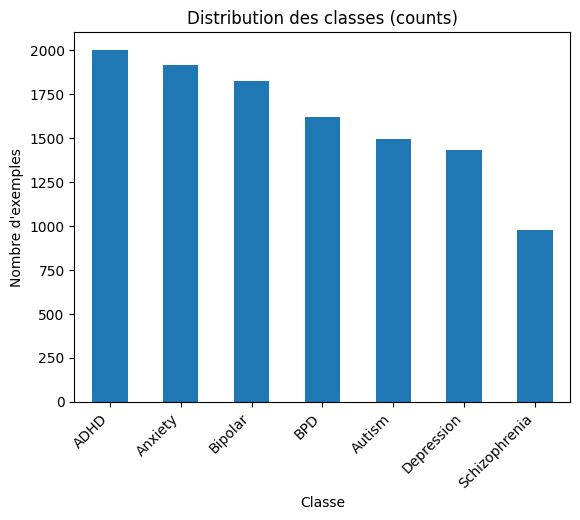

In [10]:
# Distribution des classes
label_counts = df[TARGET_COL].value_counts()
display(label_counts)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution des classes (counts)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=45, ha="right")
plt.show()


,n_chars,n_words
count,11270.000000,11270.000000
mean,1178.362023,228.633274
std,1290.430307,249.530744
min,1.000000,1.000000
25%,426.250000,83.000000
50%,797.000000,156.000000
75%,1468.750000,286.000000
max,26803.000000,5411.000000


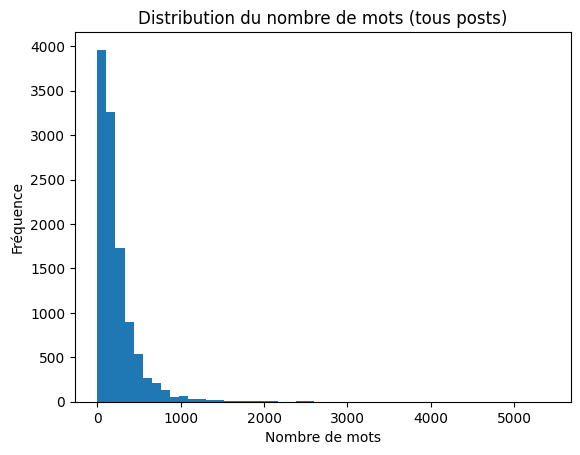

In [11]:
# Longueurs (chars et mots)
df["n_chars"] = df[TEXT_COL].astype(str).str.len()
df["n_words"] = df[TEXT_COL].astype(str).str.split().map(len)

display(df[["n_chars","n_words"]].describe())

plt.figure()
plt.hist(df["n_words"], bins=50)
plt.title("Distribution du nombre de mots (tous posts)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


## 5) Analyse par classe (boxplots + exemples)
**Pourquoi :** certaines classes ont souvent des posts plus longs/plus courts, ce qui peut influencer le modèle.  
**Conclusion :** vérifier si la longueur est un *feature* utile (→ score hybride).


/tmp/ipython-input-252141682.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=classes, showfliers=False)


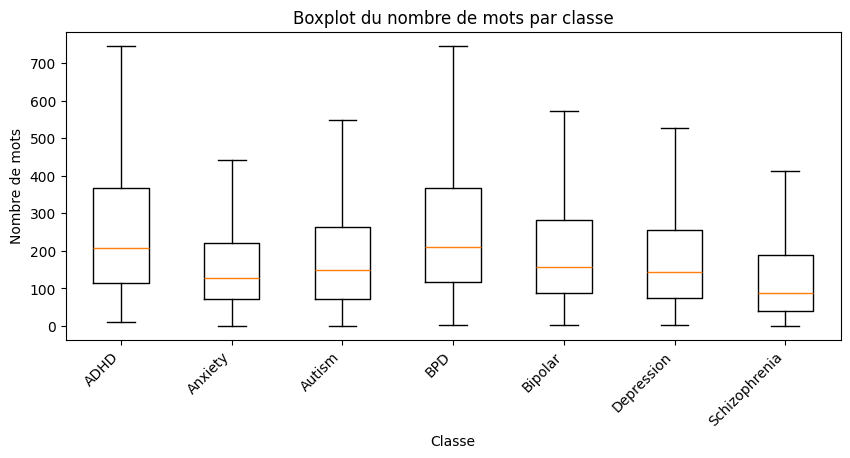


--- Exemples (ADHD) ---
- does anyone else with adhd have a great sense of adventure i dont necessarily mean just going out in nature but a sense of learning and trying new things constantly and being creative i always love going out in nature an...
- dont be to hard on yourself i know you dont want to hear this and i understand that it likely feels condescending or as if i wasnt taking you seriously take it from someone whos just a few years further in life and who e...

--- Exemples (Anxiety) ---
- i usually dont get very anxious but last week was one of the worst weeks ive ever had it started by having anxious thoughts to suddenly breaking down and shaking in the middle of a restaurant and wishing lightning struck...
- most of my anxiety is focused around money i have a really strict budget most of the time i would rather be hungry then spend money to eat even when i do have the money i really need new clothes im 20m and most of the cl...

--- Exemples (Autism) ---
- ive started go

In [12]:
# Boxplot n_words par classe (bloxplots)
classes = sorted(df[TARGET_COL].unique())
data = [df.loc[df[TARGET_COL]==c, "n_words"].values for c in classes]

plt.figure(figsize=(10,4))
plt.boxplot(data, labels=classes, showfliers=False)
plt.title("Boxplot du nombre de mots par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre de mots")
plt.xticks(rotation=45, ha="right")
plt.show()

# Quelques exemples par classe (aléatoires)
for c in classes:
    ex = df[df[TARGET_COL]==c].sample(2, random_state=42)[TEXT_COL].tolist()
    print(f"\n--- Exemples ({c}) ---")
    for t in ex:
        print("-", t[:220].replace("\n"," ") + ("..." if len(t)>220 else ""))


## 6) Analyse linguistique (mots fréquents)
**Pourquoi :** repérer du vocabulaire discriminant (et surtout détecter la fuite d’information via mots diagnostiques).  
**Conclusion :** décider si on doit tester un **masquage** (mask) pour éviter que le modèle triche.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def top_terms(texts, n=20):
    vec = CountVectorizer(
        stop_words=None,   # ✅ NÃO remove stopwords
        min_df=5,
        lowercase=True     # já deve estar, mas reforça
    )
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = freqs.argsort()[::-1][:n]
    return list(zip(vocab[top_idx], freqs[top_idx]))

# top terms global
top_global = top_terms(df[TEXT_COL].astype(str).tolist(), n=25)
print("Top mots (global):")
print(top_global)

# top terms sur classes critiques
classes = df[TARGET_COL].unique()

for c in ["Schizophrenia", "Bipolar"]:
    if c in classes:
        top_c = top_terms(
            df[df[TARGET_COL]==c][TEXT_COL].astype(str).tolist(),
            n=20
        )
        print(f"\nTop mots ({c}):")
        print(top_c)

Top mots (global):
[('to', np.int64(85520)), ('and', np.int64(83764)), ('the', np.int64(60618)), ('my', np.int64(44239)), ('of', np.int64(38885)), ('that', np.int64(32033)), ('it', np.int64(31736)), ('me', np.int64(31093)), ('in', np.int64(29213)), ('for', np.int64(25985)), ('is', np.int64(24121)), ('but', np.int64(23998)), ('with', np.int64(22777)), ('im', np.int64(21593)), ('have', np.int64(21572)), ('this', np.int64(20951)), ('was', np.int64(20756)), ('so', np.int64(17785)), ('just', np.int64(16599)), ('on', np.int64(16302)), ('like', np.int64(15698)), ('you', np.int64(14814)), ('not', np.int64(14538)), ('or', np.int64(14446)), ('she', np.int64(14227))]

Top mots (Schizophrenia):
[('and', np.int64(4723)), ('to', np.int64(4637)), ('the', np.int64(3440)), ('my', np.int64(2703)), ('of', np.int64(2234)), ('in', np.int64(1826)), ('that', np.int64(1765)), ('me', np.int64(1745)), ('it', np.int64(1717)), ('is', np.int64(1561)), ('was', np.int64(1420)), ('but', np.int64(1364)), ('for', np.in

# Phase 2 — Modélisation
## 7) Split fixe + masquage (avec/sans)
**Pourquoi :**  
- Un **split fixe** rend les comparaisons de modèles fiables.  
- Le **masquage** enlève les mots directement diagnostiques (ex: “ADHD”, “bipolar”) pour tester la robustesse.

**Conclusion :** on entraîne et compare **2 pipelines** : *sans mask* vs *avec mask*.


In [14]:
RANDOM_STATE = 42
TEST_SIZE = 0.15
CRITICAL = ["Schizophrenia", "Bipolar"]

# Nettoyage minimal identique pour tous les modèles
df_eval = df[[TEXT_COL, TARGET_COL]].copy()
df_eval[TEXT_COL] = df_eval[TEXT_COL].astype(str)
df_eval[TARGET_COL] = df_eval[TARGET_COL].astype(str)

# Remove exact duplicates (texte + label)
df_eval = df_eval.drop_duplicates(subset=[TEXT_COL, TARGET_COL]).reset_index(drop=True)

idx = np.arange(len(df_eval))
train_idx, test_idx = train_test_split(
    idx,
    test_size=TEST_SIZE,
    stratify=df_eval[TARGET_COL],
    random_state=RANDOM_STATE
)

train_df = df_eval.iloc[train_idx].reset_index(drop=True)
test_df  = df_eval.iloc[test_idx].reset_index(drop=True)

labels = sorted(df_eval[TARGET_COL].unique())
print("N:", len(df_eval))
print("Classes:", labels)
print(f"Split fixe: train={len(train_df)} | test={len(test_df)}")


N: 10486
Classes: ['ADHD', 'Anxiety', 'Autism', 'BPD', 'Bipolar', 'Depression', 'Schizophrenia']
Split fixe: train=8913 | test=1573


In [15]:
# Masquage diagnostique: enlève les termes directement liés aux labels
DIAG_PATTERNS = [
    r"\badhd\b", r"\badd\b",
    r"\banxiety\b",
    r"\bautism\b", r"\basd\b",
    r"\bbpd\b", r"\bborderline\b",
    r"\bbipolar\b",
    r"\bdepression\b", r"\bdepressed\b",
    r"\bschizophrenia\b", r"\bschizo\b", r"\bpsychosis\b",
    # variantes possibles
    r"\bdiagnosed\b", r"\bdiagnosis\b"
]
DIAG_RE = re.compile("|".join(DIAG_PATTERNS), flags=re.IGNORECASE)

def mask_diagnostic(text: str) -> str:
    return DIAG_RE.sub("[MASK_DIAG]", str(text))

train_df["body_masked"] = train_df[TEXT_COL].map(mask_diagnostic)
test_df["body_masked"]  = test_df[TEXT_COL].map(mask_diagnostic)

train_df[[TEXT_COL, "body_masked"]].sample(3, random_state=42)


,body,body_masked
1688,hi folks i would really appreciate any kind words advice etc i have struggled with relationships all of my life i re...,hi folks i would really appreciate any kind words advice etc i have struggled with relationships all of my life i re...
5852,tomorrow is the day im going to let my bipolar spouse know that i am leaving i have rented an apartment which is ava...,tomorrow is the day im going to let my [MASK_DIAG] spouse know that i am leaving i have rented an apartment which is...
4581,dont spiral dont spiral dont spiral dont spiral dont spiral dont spiral e i love you all so fucking much,dont spiral dont spiral dont spiral dont spiral dont spiral dont spiral e i love you all so fucking much


## 8) Baselines rapides (TF‑IDF + modèles linéaires)
**Pourquoi :** les modèles linéaires + TF‑IDF donnent souvent un excellent rapport performance / vitesse / explicabilité.  
**Conclusion :** sélectionner une baseline solide avant tuning (et vérifier l’impact du masquage).


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

def eval_model(model, X_train, y_train, X_test, y_test, labels):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    f1m = f1_score(y_test, pred, average="macro")
    rcm = recall_score(y_test, pred, average="macro", zero_division=0)

    per = recall_score(y_test, pred, average=None, labels=labels, zero_division=0)
    per_map = dict(zip(labels, per))
    crit_vals = [per_map[c] for c in CRITICAL if c in per_map]
    rcrit = float(np.mean(crit_vals)) if len(crit_vals) else np.nan

    return {
        "f1_macro": float(f1m),
        "recall_macro": float(rcm),
        "recall_critical_mean": float(rcrit),
        "pred": pred
    }

def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.tight_layout()
    plt.show()

def baseline_models():
    def tfidf():
        return TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)

    return {
        "TFIDF + LinearSVC": Pipeline([("tfidf", tfidf()), ("clf", LinearSVC())]),
        "TFIDF + LinearSVC (balanced)": Pipeline([("tfidf", tfidf()), ("clf", LinearSVC(class_weight="balanced"))]),
        "TFIDF + LogReg (saga)": Pipeline([("tfidf", tfidf()), ("clf", LogisticRegression(solver="saga", max_iter=2000))]),
        "TFIDF + LogReg (OvR)": Pipeline([("tfidf", tfidf()), ("clf", OneVsRestClassifier(LogisticRegression(solver="saga", max_iter=2000)))]),
        "TFIDF + MultinomialNB": Pipeline([("tfidf", tfidf()), ("clf", MultinomialNB())]),
    }

all_results = []  # pour le tableau final


In [17]:
# Baselines: sans mask vs avec mask
models = baseline_models()

for use_mask in [False, True]:
    Xtr = train_df["body_masked"] if use_mask else train_df[TEXT_COL]
    Xte = test_df["body_masked"]  if use_mask else test_df[TEXT_COL]

    print("\n" + "="*80)
    print("Baselines —", "AVEC masquage" if use_mask else "SANS masquage")

    for name, model in models.items():
        out = eval_model(model, Xtr, train_df[TARGET_COL], Xte, test_df[TARGET_COL], labels)
        print(f"{name:30s} | f1_macro={out['f1_macro']:.4f} | recall_macro={out['recall_macro']:.4f} | recall_critical={out['recall_critical_mean']:.4f}")

        all_results.append({
            "experiment": f"baseline/{name}",
            "mask": use_mask,
            **{k: out[k] for k in ["f1_macro","recall_macro","recall_critical_mean"]}
        })



Baselines — SANS masquage
TFIDF + LinearSVC              | f1_macro=0.7289 | recall_macro=0.7204 | recall_critical=0.6281
TFIDF + LinearSVC (balanced)   | f1_macro=0.7391 | recall_macro=0.7340 | recall_critical=0.6515
TFIDF + LogReg (saga)          | f1_macro=0.6588 | recall_macro=0.6491 | recall_critical=0.5504
TFIDF + LogReg (OvR)           | f1_macro=0.6440 | recall_macro=0.6373 | recall_critical=0.5298
TFIDF + MultinomialNB          | f1_macro=0.3986 | recall_macro=0.4678 | recall_critical=0.3238

Baselines — AVEC masquage
TFIDF + LinearSVC              | f1_macro=0.6707 | recall_macro=0.6619 | recall_critical=0.5714
TFIDF + LinearSVC (balanced)   | f1_macro=0.6731 | recall_macro=0.6677 | recall_critical=0.5830
TFIDF + LogReg (saga)          | f1_macro=0.5783 | recall_macro=0.5778 | recall_critical=0.4337
TFIDF + LogReg (OvR)           | f1_macro=0.5603 | recall_macro=0.5626 | recall_critical=0.4132
TFIDF + MultinomialNB          | f1_macro=0.3707 | recall_macro=0.4388 | recall_cr

## 9) Tuning orienté *recall critique* (SVC + poids classes)
**Pourquoi :** ton objectif prioritaire est le **recall** sur *Schizophrenia* et *Bipolar*.  
On renforce ces classes via `class_weight` (paramètre `crit_weight`) et on tune quelques hyperparamètres TF‑IDF / SVC.

**Conclusion :** obtenir une config “TOP1 CV” et la valider sur le test fixe.


## 10) Score hybride: TF‑IDF + features linguistiques
**Pourquoi :** l’EDA suggère que des signaux simples (longueur, ponctuation, majuscules, chiffres) peuvent aider, surtout pour certaines classes.  
On teste un *hybride* léger : TF‑IDF + features numériques.

**Conclusion :** vérifier si ça améliore le recall critique sans trop dégrader le reste.



Tuning SVC — SANS masquage


,tfidf_ngram_range,tfidf_min_df,tfidf_sublinear_tf,clf_C,crit_weight,f1_macro_mean,recall_macro_mean,recall_critical_mean,f1_macro_std,recall_macro_std,recall_critical_std
0,"(1, 1)",2,True,0.5,3.0,0.749844,0.743220,0.736566,0.006359,0.006244,0.022201
1,"(1, 1)",1,True,0.5,2.0,0.754277,0.746986,0.721783,0.008719,0.008215,0.021216
2,"(1, 2)",2,True,1.0,3.0,0.746966,0.737670,0.707756,0.011891,0.011371,0.022637


TOP1 (CV): {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 2, 'tfidf__sublinear_tf': True, 'clf__C': 0.5, 'crit_weight': 3.0, 'clf__class_weight': {'ADHD': 1.0, 'Anxiety': 1.0, 'Autism': 1.0, 'BPD': 1.0, 'Bipolar': 3.0, 'Depression': 1.0, 'Schizophrenia': 3.0}}

=== SVC Tuné — TEST fixe ===
f1_macro: 0.7346468740695313
recall_macro: 0.7278486422320615
recall_critical_mean: 0.7012683916793506

Report (TEST):
               precision    recall  f1-score   support

         ADHD       0.90      0.88      0.89       276
      Anxiety       0.74      0.83      0.78       286
       Autism       0.81      0.58      0.68       141
          BPD       0.85      0.71      0.77       242
      Bipolar       0.66      0.75      0.70       270
   Depression       0.66      0.70      0.68       212
Schizophrenia       0.63      0.65      0.64       146

     accuracy                           0.75      1573
    macro avg       0.75      0.73      0.73      1573
 weighted avg       0.76      0.75   

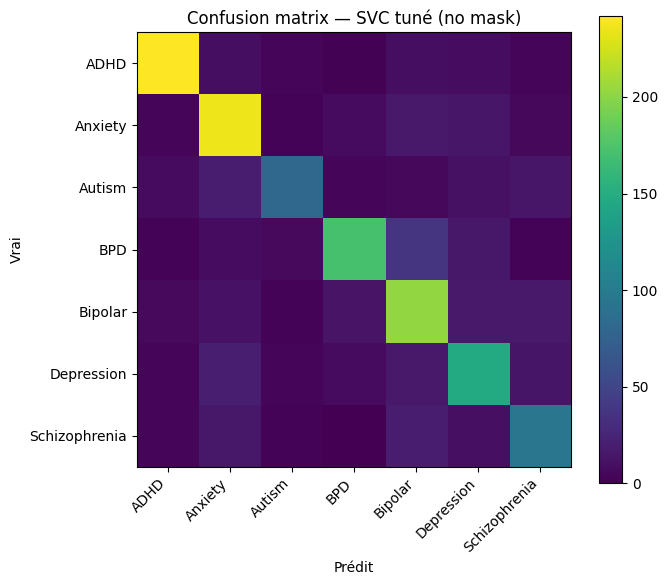


Tuning SVC — AVEC masquage


,tfidf_ngram_range,tfidf_min_df,tfidf_sublinear_tf,clf_C,crit_weight,f1_macro_mean,recall_macro_mean,recall_critical_mean,f1_macro_std,recall_macro_std,recall_critical_std
0,"(1, 1)",2,True,0.5,3.0,0.672506,0.665433,0.667214,0.008276,0.008021,0.024973
1,"(1, 1)",1,True,0.5,2.0,0.677869,0.670449,0.644648,0.008533,0.007941,0.018386
2,"(1, 2)",2,True,1.0,3.0,0.676533,0.667459,0.635845,0.012746,0.011064,0.014548


TOP1 (CV): {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 2, 'tfidf__sublinear_tf': True, 'clf__C': 0.5, 'crit_weight': 3.0, 'clf__class_weight': {'ADHD': 1.0, 'Anxiety': 1.0, 'Autism': 1.0, 'BPD': 1.0, 'Bipolar': 3.0, 'Depression': 1.0, 'Schizophrenia': 3.0}}

=== SVC Tuné — TEST fixe ===
f1_macro: 0.6520724711976777
recall_macro: 0.6452307338377793
recall_critical_mean: 0.6289700659563673

Report (TEST):
               precision    recall  f1-score   support

         ADHD       0.82      0.84      0.83       276
      Anxiety       0.68      0.74      0.71       286
       Autism       0.80      0.45      0.58       141
          BPD       0.71      0.66      0.68       242
      Bipolar       0.59      0.70      0.64       270
   Depression       0.59      0.57      0.58       212
Schizophrenia       0.52      0.56      0.54       146

     accuracy                           0.67      1573
    macro avg       0.67      0.65      0.65      1573
 weighted avg       0.68      0.67   

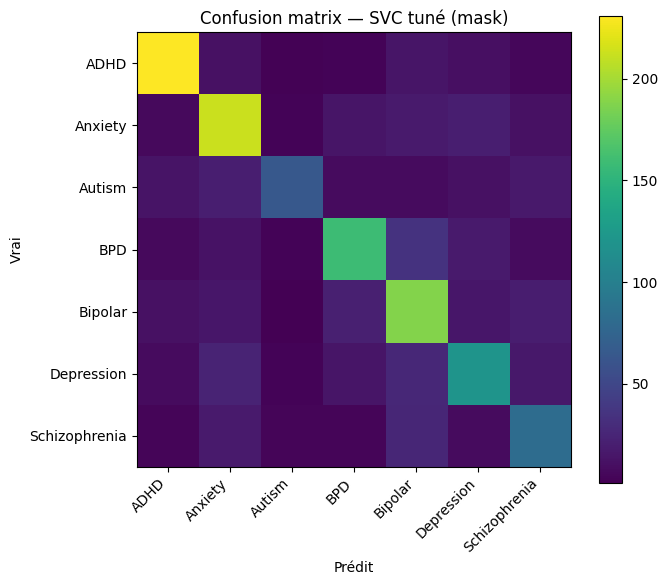

In [18]:
def critical_recall(y_true, y_pred, labels):
    per = recall_score(y_true, y_pred, average=None, labels=labels, zero_division=0)
    per_map = dict(zip(labels, per))
    vals = [per_map[c] for c in CRITICAL if c in per_map]
    return float(np.mean(vals)) if len(vals) else np.nan

def tune_svc_weighted(X_train, y_train, labels, use_mask=False, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    # ✅ GRID DE PARÂMETROS ATUALIZADO
    grid = [
        {
            "tfidf_ngram_range": (1, 1),
            "tfidf_min_df": 2,
            "tfidf_sublinear_tf": True,
            "clf_C": 0.5,
            "crit_weight": 3.0
        },
        # Adicione outras combinações se quiser testar mais parâmetros
        {
            "tfidf_ngram_range": (1, 2),
            "tfidf_min_df": 2,
            "tfidf_sublinear_tf": True,
            "clf_C": 1.0,
            "crit_weight": 3.0
        },
        {
            "tfidf_ngram_range": (1, 1),
            "tfidf_min_df": 1,
            "tfidf_sublinear_tf": True,
            "clf_C": 0.5,
            "crit_weight": 2.0
        }
    ]

    rows = []
    for params in grid:
        crit_w = params["crit_weight"]
        p = {k: v for k, v in params.items() if k != "crit_weight"}

        cw = {lab: 1.0 for lab in labels}
        for c in CRITICAL:
            if c in cw:
                cw[c] = crit_w

        model = Pipeline([
            ("tfidf", TfidfVectorizer(
                ngram_range=p["tfidf_ngram_range"],
                min_df=p["tfidf_min_df"],
                sublinear_tf=p["tfidf_sublinear_tf"]
            )),
            ("clf", LinearSVC(
                C=p["clf_C"],
                class_weight=cw,
                random_state=RANDOM_STATE
            ))
        ])

        f1s, rms, crits = [], [], []
        for tr, va in cv.split(X_train, y_train):
            X_tr, X_va = X_train.iloc[tr], X_train.iloc[va]
            y_tr, y_va = y_train.iloc[tr], y_train.iloc[va]

            model.fit(X_tr, y_tr)
            pred = model.predict(X_va)

            f1s.append(f1_score(y_va, pred, average="macro"))
            rms.append(recall_score(y_va, pred, average="macro", zero_division=0))
            crits.append(critical_recall(y_va, pred, labels))

        rows.append({
            "tfidf_ngram_range": p["tfidf_ngram_range"],
            "tfidf_min_df": p["tfidf_min_df"],
            "tfidf_sublinear_tf": p["tfidf_sublinear_tf"],
            "clf_C": p["clf_C"],
            "crit_weight": crit_w,
            "f1_macro_mean": float(np.mean(f1s)),
            "recall_macro_mean": float(np.mean(rms)),
            "recall_critical_mean": float(np.mean(crits)),
            "f1_macro_std": float(np.std(f1s)),
            "recall_macro_std": float(np.std(rms)),
            "recall_critical_std": float(np.std(crits)),
        })

    res = pd.DataFrame(rows).sort_values(
        by=["recall_critical_mean", "recall_macro_mean", "f1_macro_mean"],
        ascending=False
    ).reset_index(drop=True)

    # ✅ best params = primeira linha após ordenar
    best_row = res.iloc[0].to_dict()

    best_params = {
        "tfidf__ngram_range": best_row["tfidf_ngram_range"],
        "tfidf__min_df": best_row["tfidf_min_df"],
        "tfidf__sublinear_tf": best_row["tfidf_sublinear_tf"],
        "clf__C": best_row["clf_C"],
        "crit_weight": best_row["crit_weight"],
        "clf__class_weight": {
            **{lab: 1.0 for lab in labels},
            **{c: best_row["crit_weight"] for c in CRITICAL if c in labels}
        }
    }

    return res, best_params

# ✅ CÓDIGO DE TUNING CORRIGIDO
for use_mask in [False, True]:
    Xtr = train_df["body_masked"] if use_mask else train_df[TEXT_COL]
    ytr = train_df[TARGET_COL]

    print("\n" + "="*80)
    print("Tuning SVC —", "AVEC masquage" if use_mask else "SANS masquage")

    res, best_params = tune_svc_weighted(Xtr, ytr, labels, use_mask=use_mask, n_splits=5)
    display(res.head(10))

    print("TOP1 (CV):", best_params)

    # ✅ TRAIN TOP1 + EVAL TEST CORRIGIDO
    best_model = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=best_params["tfidf__ngram_range"],
            min_df=best_params["tfidf__min_df"],
            sublinear_tf=best_params["tfidf__sublinear_tf"]
        )),
        ("clf", LinearSVC(
            C=best_params["clf__C"],
            class_weight=best_params["clf__class_weight"],
            random_state=RANDOM_STATE
        ))
    ])

    Xte = test_df["body_masked"] if use_mask else test_df[TEXT_COL]
    out = eval_model(best_model, Xtr, ytr, Xte, test_df[TARGET_COL], labels)

    print("\n=== SVC Tuné — TEST fixe ===")
    print("f1_macro:", out["f1_macro"])
    print("recall_macro:", out["recall_macro"])
    print("recall_critical_mean:", out["recall_critical_mean"])
    print("\nReport (TEST):")
    print(classification_report(test_df[TARGET_COL], out["pred"], labels=labels, zero_division=0))

    plot_confusion(test_df[TARGET_COL], out["pred"], labels, f"Confusion matrix — SVC tuné ({'mask' if use_mask else 'no mask'})")

    all_results.append({
        "experiment": "tuned_svc",
        "mask": use_mask,
        "f1_macro": out["f1_macro"],
        "recall_macro": out["recall_macro"],
        "recall_critical_mean": out["recall_critical_mean"],
    })


In [19]:
# Features linguistiques simples
class TextStatsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X).astype(str)
        n_chars = X.str.len().values
        n_words = X.str.split().map(len).values
        n_excl  = X.str.count("!").values
        n_quest = X.str.count("\?").values
        n_digits = X.str.count(r"\d").values
        upper_ratio = X.apply(lambda s: sum(ch.isupper() for ch in s) / max(1, len(s))).values

        feats = np.vstack([n_chars, n_words, n_excl, n_quest, n_digits, upper_ratio]).T
        return feats

def make_hybrid_model(class_weight=None, C=1.0, ngram_range=(1,2), min_df=2):
    tfidf = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, sublinear_tf=True)
    stats = Pipeline([("stats", TextStatsTransformer()), ("scale", StandardScaler(with_mean=False))])

    union = FeatureUnion([
        ("tfidf", tfidf),
        ("stats", stats)
    ])
    clf = LinearSVC(C=C, class_weight=class_weight)
    return Pipeline([("features", union), ("clf", clf)])


<>:11: SyntaxWarning: invalid escape sequence '\?'
<>:11: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-803194980.py:11: SyntaxWarning: invalid escape sequence '\?'
  n_quest = X.str.count("\?").values


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Hybride (no mask) | f1_macro=0.7325 | recall_macro=0.7240 | recall_critical=0.6722


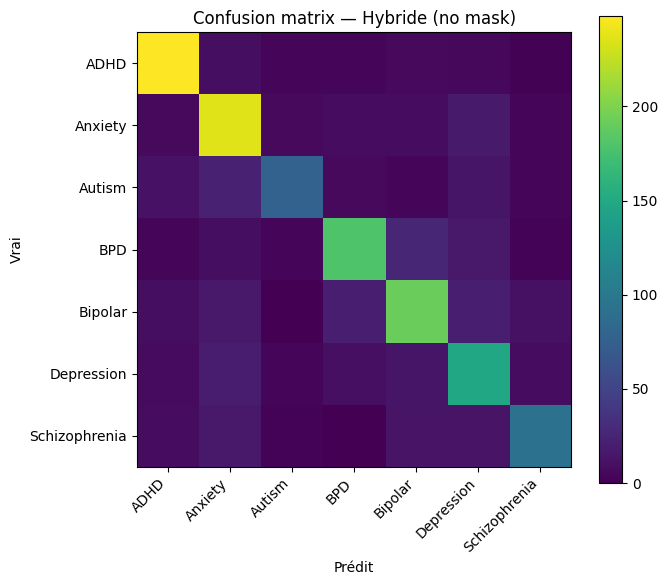

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Hybride (mask) | f1_macro=0.6627 | recall_macro=0.6553 | recall_critical=0.5946


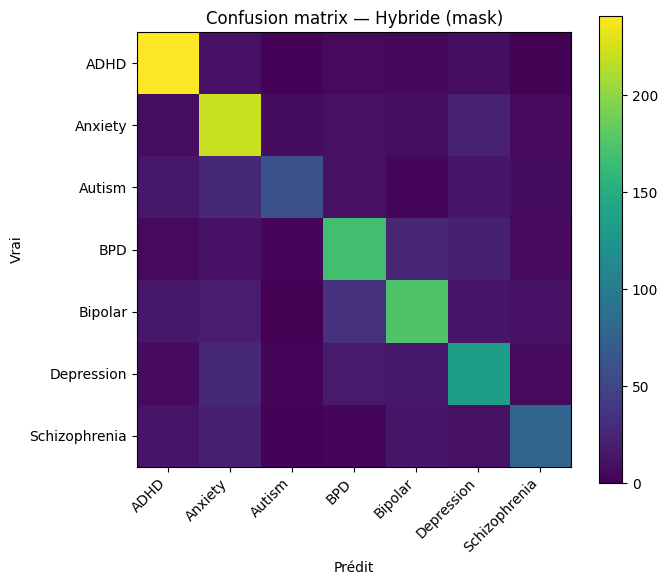

In [20]:
# Hybride: on reprend l'idée du SVC pondéré (crit_weight)
def hybrid_run(use_mask=False, crit_weight=2.0, C=1.0, min_df=2, ngram=(1,2)):
    cw = {lab: 1.0 for lab in labels}
    for c in CRITICAL:
        if c in cw:
            cw[c] = crit_weight

    model = make_hybrid_model(class_weight=cw, C=C, ngram_range=ngram, min_df=min_df)

    Xtr = train_df["body_masked"] if use_mask else train_df[TEXT_COL]
    Xte = test_df["body_masked"]  if use_mask else test_df[TEXT_COL]

    out = eval_model(model, Xtr, train_df[TARGET_COL], Xte, test_df[TARGET_COL], labels)
    print(f"Hybride ({'mask' if use_mask else 'no mask'}) | f1_macro={out['f1_macro']:.4f} | recall_macro={out['recall_macro']:.4f} | recall_critical={out['recall_critical_mean']:.4f}")
    plot_confusion(test_df[TARGET_COL], out["pred"], labels, f"Confusion matrix — Hybride ({'mask' if use_mask else 'no mask'})")

    all_results.append({
        "experiment": "hybrid_svc",
        "mask": use_mask,
        "f1_macro": out["f1_macro"],
        "recall_macro": out["recall_macro"],
        "recall_critical_mean": out["recall_critical_mean"],
    })

# Run simple (tu peux aussi tuner ces params si tu veux)
hybrid_run(use_mask=False, crit_weight=2.0, C=1.0, min_df=2, ngram=(1,2))
hybrid_run(use_mask=True,  crit_weight=2.0, C=1.0, min_df=2, ngram=(1,2))


## 11) Transformers (BERT) + comparaison
**Pourquoi :** BERT peut capter du contexte plus fin que TF‑IDF, mais il est plus coûteux et parfois moins robuste si le dataset est petit/bruillant.  
On teste **bert-base-uncased** (accessible) et on garde une section pour les modèles *gated* (ex: MentalBERT) avec solution d’authentification.

**Conclusion :** comparer aux modèles TF‑IDF, surtout sur **recall critique**.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HF account: {'type': 'user', 'id': '696b74f4323a85d56a64987f', 'name': 'anafg', 'fullname': 'ana gouveia', 'email': 'anafiiliipa@hotmail.com', 'emailVerified': True, 'canPay': False, 'billingMode': 'prepaid', 'periodEnd': 1772323200, 'isPro': False, 'avatarUrl': '/avatars/abe555f759dcec31c75c5072812f3d88.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'Clé API 1', 'role': 'write', 'createdAt': '2026-02-17T17:44:36.985Z'}}}


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8913 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Recall Critical Mean
1,0.752081,0.750767,0.738402,0.733521,0.689320



BERT: bert-base-uncased | no mask
{'eval_f1_macro': 0.7384019350783452, 'eval_recall_macro': 0.7335214014428529, 'eval_recall_critical_mean': 0.689320142059868}


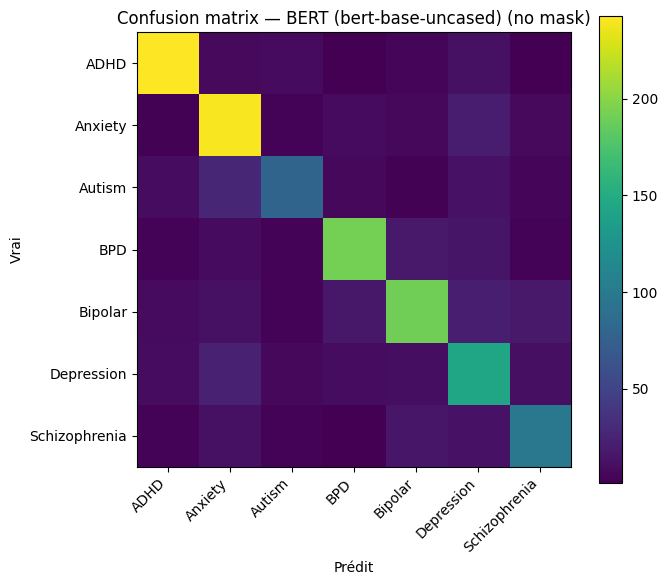

Map:   0%|          | 0/8913 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Recall Critical Mean
1,0.964618,0.954498,0.659895,0.652742,0.595637



BERT: bert-base-uncased | mask
{'eval_f1_macro': 0.6598953205103764, 'eval_recall_macro': 0.6527416960720694, 'eval_recall_critical_mean': 0.5956367326230341}


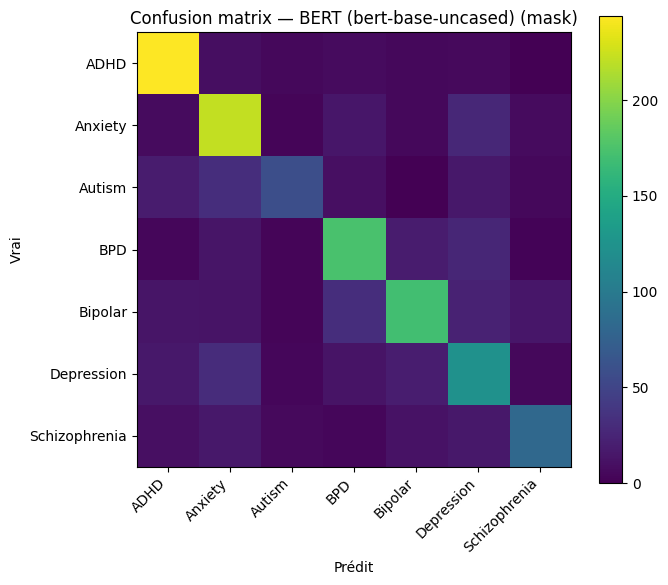

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/8913 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: mental/mental-bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if 

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Recall Critical Mean
1,0.683113,0.707511,0.758996,0.754307,0.707737



BERT: mental/mental-bert-base-uncased | no mask
{'eval_f1_macro': 0.7589958860361049, 'eval_recall_macro': 0.7543071582338255, 'eval_recall_critical_mean': 0.7077371892440385}


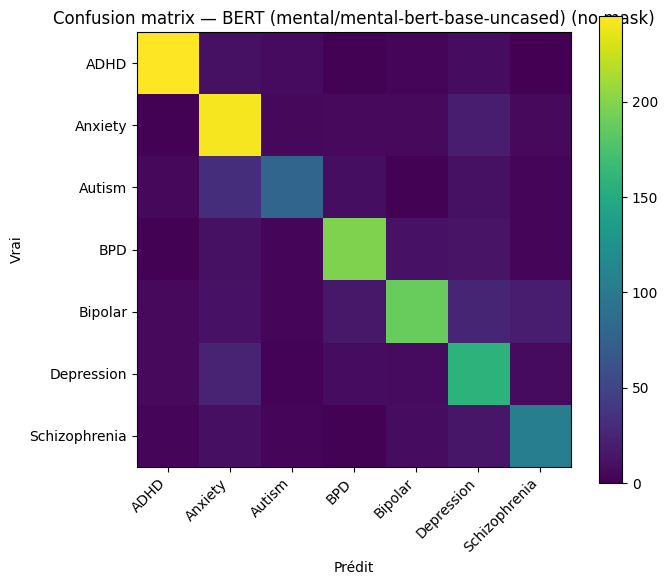

Map:   0%|          | 0/8913 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: mental/mental-bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if 

Epoch,Training Loss,Validation Loss,F1 Macro,Recall Macro,Recall Critical Mean
1,0.872622,0.869887,0.687903,0.681863,0.618316



BERT: mental/mental-bert-base-uncased | mask
{'eval_f1_macro': 0.6879029532554368, 'eval_recall_macro': 0.6818632605354609, 'eval_recall_critical_mean': 0.6183155758498224}


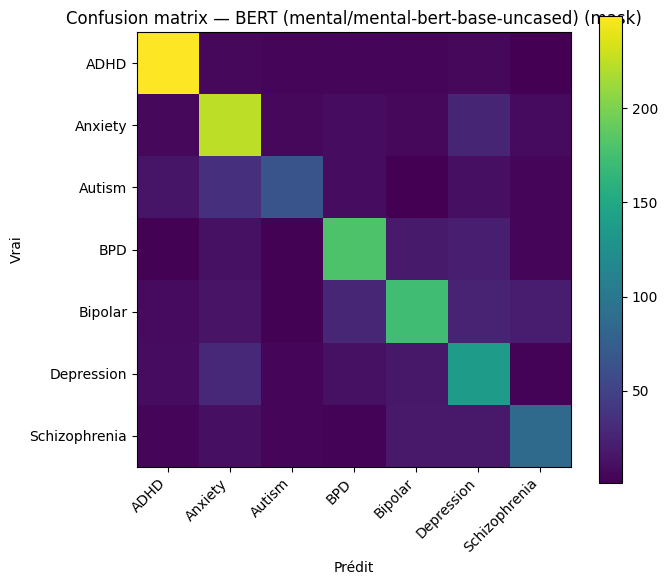

In [21]:
# =========================
# 11) Transformers (BERT) + comparaison (transformers 5.0.0)
# =========================

# (A) Login HF (só necessário para modelos gated tipo MentalBERT)
!pip -q install -U huggingface_hub
from huggingface_hub import notebook_login, whoami

notebook_login()
print("HF account:", whoami())  # deve mostrar teu username

import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

set_seed(RANDOM_STATE)

def make_training_args(output_dir, epochs, lr, train_bs, eval_bs):
    common = dict(
        output_dir=output_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=train_bs,
        per_device_eval_batch_size=eval_bs,
        save_strategy="no",
        logging_steps=50,
        report_to="none",
        fp16=torch.cuda.is_available(),
        seed=RANDOM_STATE,
    )
    # transformers 5.x aceita evaluation_strategy (normalmente), mas deixamos compat
    try:
        return TrainingArguments(evaluation_strategy="epoch", **common)
    except TypeError:
        return TrainingArguments(eval_strategy="epoch", **common)

def compute_metrics_builder(labels):
    def compute_metrics(eval_pred):
        logits, y_true = eval_pred
        y_pred = logits.argmax(axis=-1)

        f1m = f1_score(y_true, y_pred, average="macro")
        rcm = recall_score(y_true, y_pred, average="macro", zero_division=0)

        per = recall_score(
            y_true, y_pred,
            average=None,
            labels=list(range(len(labels))),
            zero_division=0
        )
        per_map = {labels[i]: per[i] for i in range(len(labels))}
        crit_vals = [per_map[c] for c in CRITICAL if c in per_map]
        rcrit = float(np.mean(crit_vals)) if len(crit_vals) else np.nan

        metrics = {
            "f1_macro": float(f1m),
            "recall_macro": float(rcm),
            "recall_critical_mean": float(rcrit),
        }
        return metrics

    return compute_metrics

def run_bert(
    model_name,
    use_mask=False,
    max_len=256,
    epochs=1,
    lr=2e-5,
    train_bs=8,
    eval_bs=16,
    use_hf_token=True,       # True para gated; False para público
):
    # Sélection du texte
    Xtr = train_df["body_masked"] if use_mask else train_df[TEXT_COL]
    Xte = test_df["body_masked"]  if use_mask else test_df[TEXT_COL]

    # mapping labels -> ids
    label2id = {l:i for i,l in enumerate(labels)}
    id2label = {i:l for l,i in label2id.items()}

    train_ds = Dataset.from_dict({
        "text": Xtr.astype(str).tolist(),
        "label": [label2id[str(y)] for y in train_df[TARGET_COL].astype(str).tolist()]
    })
    test_ds  = Dataset.from_dict({
        "text": Xte.astype(str).tolist(),
        "label": [label2id[str(y)] for y in test_df[TARGET_COL].astype(str).tolist()]
    })

    # ✅ token=True força a usar o token do notebook_login (necessário para gated)
    tok = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=True,
        token=True if use_hf_token else None
    )

    def tokenize(batch):
        return tok(batch["text"], truncation=True, max_length=max_len)

    train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"])
    test_ds  = test_ds.map(tokenize, batched=True, remove_columns=["text"])

    data_collator = DataCollatorWithPadding(tokenizer=tok)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
        token=True if use_hf_token else None
    )

    args = make_training_args(
        output_dir=f"./tmp_{model_name.replace('/','_')}_{'mask' if use_mask else 'nomask'}",
        epochs=epochs,
        lr=lr,
        train_bs=train_bs,
        eval_bs=eval_bs,
    )

    # ✅ transformers 5.x -> processing_class
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,           # (nota) isto é o teu "test fixe"
        processing_class=tok,
        data_collator=data_collator,
        compute_metrics=compute_metrics_builder(labels)
    )

    trainer.train()
    metrics = trainer.evaluate()

    print("\nBERT:", model_name, "|", "mask" if use_mask else "no mask")
    print({
        "eval_f1_macro": metrics.get("eval_f1_macro"),
        "eval_recall_macro": metrics.get("eval_recall_macro"),
        "eval_recall_critical_mean": metrics.get("eval_recall_critical_mean")
    })

    # prédictions pour confusion matrix
    preds = trainer.predict(test_ds).predictions.argmax(axis=-1)
    y_true = np.array(test_ds["label"])
    y_pred = preds

    y_true_lab = [labels[i] for i in y_true]
    y_pred_lab = [labels[i] for i in y_pred]

    plot_confusion(
        y_true_lab, y_pred_lab, labels,
        f"Confusion matrix — BERT ({model_name}) ({'mask' if use_mask else 'no mask'})"
    )

    # stocker résultats
    all_results.append({
        "experiment": f"bert/{model_name}",
        "mask": use_mask,
        "f1_macro": float(metrics.get("eval_f1_macro", np.nan)),
        "recall_macro": float(metrics.get("eval_recall_macro", np.nan)),
        "recall_critical_mean": float(metrics.get("eval_recall_critical_mean", np.nan)),
    })

# ✅ Runs: modelo público (não precisa token)
run_bert("bert-base-uncased", use_mask=False, epochs=1, use_hf_token=False)
run_bert("bert-base-uncased", use_mask=True,  epochs=1, use_hf_token=False)

# ✅ Runs: MentalBERT (gated) — agora que já tens acesso + login
run_bert("mental/mental-bert-base-uncased", use_mask=False, epochs=1, use_hf_token=True)
run_bert("mental/mental-bert-base-uncased", use_mask=True,  epochs=1, use_hf_token=True)

### Note: MentalBERT / modèles gated (401)
Tu as eu une erreur 401 sur `mental/mental-bert-base-uncased` parce que c’est un dépôt **restreint (gated)**.  
**Solution :** te connecter à Hugging Face dans Colab, puis relancer.

```bash
!pip -q install -U huggingface_hub
from huggingface_hub import notebook_login
notebook_login()
```

Ensuite:
```python
run_bert("mental/mental-bert-base-uncased", use_mask=False, epochs=1)
```

> Si tu veux éviter les modèles gated : utilise des modèles “public” (BERT, DistilBERT, RoBERTa).


## 12) Tableau comparatif final (tous tests)
**Pourquoi :** quand on a beaucoup d’essais, un tableau unique évite de se perdre.  
**Conclusion :** choisir le meilleur compromis selon ta priorité (souvent **recall_critical_mean** en premier).


In [22]:
# =========================
# 12) Tableau comparatif final
# =========================
res_all = pd.DataFrame(all_results)

res_all = res_all.sort_values(
    by=["recall_critical_mean","recall_macro","f1_macro"],
    ascending=False
).reset_index(drop=True)

display(res_all)

if len(res_all):
    best = res_all.iloc[0]
    print("\n Meilleur (priorité recall_critical):")
    display(best)

    print("\n Recommandation (selon priorité clinique):")
    print(f"- Modèle: {best['experiment']}")
    print(f"- Mask: {best['mask']}")
    print(f"- recall_critical_mean: {best['recall_critical_mean']:.4f}")
    print(f"- recall_macro: {best['recall_macro']:.4f}")
    print(f"- f1_macro: {best['f1_macro']:.4f}")

,experiment,mask,f1_macro,recall_macro,recall_critical_mean
0,bert/mental/mental-bert-base-uncased,False,0.758996,0.754307,0.707737
1,tuned_svc,False,0.734647,0.727849,0.701268
2,bert/bert-base-uncased,False,0.738402,0.733521,0.689320
3,hybrid_svc,False,0.732460,0.723992,0.672197
4,baseline/TFIDF + LinearSVC (balanced),False,0.739110,0.734034,0.651547
5,tuned_svc,True,0.652072,0.645231,0.628970
6,baseline/TFIDF + LinearSVC,False,0.728947,0.720430,0.628133
7,bert/mental/mental-bert-base-uncased,True,0.687903,0.681863,0.618316
8,bert/bert-base-uncased,True,0.659895,0.652742,0.595637
9,hybrid_svc,True,0.662744,0.655283,0.594622



 Meilleur (priorité recall_critical):


experiment              bert/mental/mental-bert-base-uncased
mask                                                   False
f1_macro                                            0.758996
recall_macro                                        0.754307
recall_critical_mean                                0.707737
Name: 0, dtype: object


 Recommandation (selon priorité clinique):
- Modèle: bert/mental/mental-bert-base-uncased
- Mask: False
- recall_critical_mean: 0.7077
- recall_macro: 0.7543
- f1_macro: 0.7590
